## 0.读取数据

In [0]:
import os
import cv2
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pylab as plt
import pandas as pd
import torch.nn as nn

In [0]:
class Testset(Dataset):
  
    def __init__(self, test_root, transform=None):
        self.test_root = test_root
        self.transform = transform
        reg = test_root + '/*.jpg'
        self.imgs_path = [file for file in glob.glob(reg)]

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        img_path = self.imgs_path[idx]
        img = cv2.imread(img_path)
        if self.transform:
          img = self.transform(img)

        item = {'img':img}
        return item


def show_batch(batch):
    plt.figure()
    imgs = batch['img']
    print(imgs.shape)
    batch_size = len(imgs)
    grid = utils.make_grid(imgs)
    plt.imshow(grid.numpy().transpose(1,2,0))
    plt.axis('off')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1.模型配置

In [0]:
class Net(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.norm0 = nn.BatchNorm2d(3, eps=1e-08)
        
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(64, eps=1e-08)
        self.nonlinear1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(64, 64, 8, stride=3) # 169
        self.norm2 = nn.BatchNorm2d(64, eps=1e-08)
        self.nonlinear2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64, 64, 5, stride=2) # 83
        self.norm3 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64, 64, 5, stride=2) # 40
        self.norm4 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(64, 64, 5) # 36
        self.norm5 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear5 = nn.ReLU()
        
        self.conv6 = nn.Conv2d(64, 64, 5) # 32
        self.norm6 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear6 = nn.ReLU()
        
        self.conv7 = nn.Conv2d(64, 64, 32) # 64, 1, 1
        self.norm7 = nn.BatchNorm2d(64, eps=1e-8)
        self.nonlinear7 = nn.ReLU()
        
        self.fc1 = nn.Linear(64, 500)
        self.norm8 = nn.BatchNorm1d(500, eps=1e-8)
        self.nonlinear8 = nn.ReLU()
        
        self.fc2 = nn.Linear(500, 400)
        self.norm9 = nn.BatchNorm1d(400, eps=1e-8)
        self.nonlinear9 = nn.ReLU()
        
        self.fc3 = nn.Linear(400, 300)
        self.normX = nn.BatchNorm1d(300, eps=1e-8)
        self.nonlinearX = nn.ReLU()
        
        self.fc4 = nn.Linear(300, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = self.norm0(x)
        out = self.nonlinear1(self.norm1(self.conv1(out)))
        out = self.nonlinear2(self.norm2(self.conv2(out)))
        out = self.nonlinear3(self.norm3(self.conv3(out)))
        out = self.nonlinear4(self.norm4(self.conv4(out)))
        out = self.nonlinear5(self.norm5(self.conv5(out)))
        out = self.nonlinear6(self.norm6(self.conv6(out)))
        out = self.nonlinear7(self.norm7(self.conv7(out)))
        
        N = out.size(0)
        out = out.view(N, -1)
        
        out = self.nonlinear8(self.norm8(self.fc1(out)))
        out = self.nonlinear9(self.norm9(self.fc2(out)))
        out = self.nonlinearX(self.normX(self.fc3(out)))
        out = self.fc4(out).view(-1).double()
        return out

## 2.预测函数

In [0]:
def inference(model_path):
    torch.cuda.empty_cache()
    model = Net()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    
    pred = None
    with torch.no_grad():
        for samples in test_loader:
            imgs = samples['img'].to(device)
            scores = model(imgs)
            scores[scores>0] = 1
            scores[scores<=0] = 0
            scores = scores.cpu().numpy().reshape(-1, 1).astype(int)
            if pred is None:
                pred = scores
            else:
                pred = np.vstack((pred, scores))
    return pred

## 3.预测结果并输出

### 3.1 训练集预测

torch.Size([32, 3, 512, 512])
Accuracy: grade predicton 0.974895, stage prediction 0.949791, total 0.962343


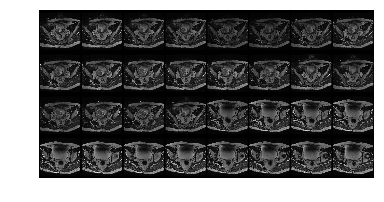

In [6]:
labels = pd.read_excel('data/DataInfo.xlsx',
              true_values=["'High'", "'MIBC'"], false_values=["'Low'","'NMIBC'"])
gt = labels.iloc[:, 1:3].values.astype(int)

testset = Testset('data/TrainingData', 
                  transforms.Compose([transforms.ToTensor()]))
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
dataiter = iter(test_loader)
show_batch(dataiter.next())

grade_pred = inference('grade_predictor.pth')
stage_pred = inference('stage_predictor.pth')
pred = np.hstack((grade_pred, stage_pred))

grade_acc = (gt[:, 0]==grade_pred.reshape(-1)).sum()/grade_pred.shape[0]
stage_acc = (gt[:, 1]==stage_pred.reshape(-1)).sum()/stage_pred.shape[0]
acc = (gt==pred).sum()/gt.size
print("Accuracy: grade predicton %f, stage prediction %f, total %f"
     % (grade_acc, stage_acc, acc))

### 3.2 测试集预测

In [0]:
grade_inf = inference('grade_predictor.pth')
stage_inf = inference('stage_predictor.pth')

testset = Testset('data/TestingData', transforms.Compose([transforms.ToTensor()]))
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)
dataiter = iter(test_loader)
show_batch(dataiter.next())

d1 = np.chararray(grade_inf.shape, 5, unicode=True)
d1[grade_inf==0]='LOW'
d1[grade_inf==1]='HIGH'

d2 = np.chararray(stage_inf.shape, 5, unicode=True)
d2[stage_inf==0]='NMIBC'
d2[stage_inf==1]='MIBC'

d = np.hstack((d1, d2))
df = pd.DataFrame(d, columns=['Grade', 'Stage'])
df.to_csv('submission.csv', index=False)